# DLinear

Ce notebook produit un modele DLinear entrainé pour chaque série et d'évalue sa performance.

Le modele est reconstruit dans pytorch 1.13 compatible avec mon GPU M640.

l'objectif est :
- tester la performance d'un modèle DLinear sur le probleme de détection des anomalies de consommation
- s'entrainer à l'utilisation de pytorch
- disposer d'un modèle DLinear compatible avec pytorch 1.13

## Imports et paramétrages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F



from sklearn.cluster import KMeans


/home/mab/anaconda3/envs/DL_torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)
print(torch.cuda.get_device_name(0))


1.13.1
Quadro M620


In [3]:
params={
'moving_avg_window':5,
'windows_batch_size':20,
'inference_windows_batch_size':10,

    
}


## Chargement et pré_traitement des données

### Chargement

In [4]:
file_path = "./data/"
project_name_eau = "detection_fuite.csv"

print("*** Chargement des données *** \n")
data_eau = pd.read_csv(f"{file_path}/{project_name_eau}")
print(f"Affichage des premières lignes du dataset : \n\n {data_eau.head()} \n\n")
print(f"Dimension du dataset : {data_eau.shape}")

*** Chargement des données *** 

Affichage des premières lignes du dataset : 

    valeur_active valeur_date libelle
0           35.0  2019-01-01    ID_1
1            0.0  2019-01-01    ID_2
2            2.0  2019-01-01    ID_3
3           38.0  2019-01-01    ID_4
4           38.0  2019-01-01    ID_5 


Dimension du dataset : (470900, 3)


In [5]:
# conversion date et tri
data_eau["date"] = pd.to_datetime(data_eau["valeur_date"])
data_eau=data_eau.sort_values(['libelle','date'])

In [6]:
# sélection des dates
start_date = "2022-01-01"
data=data_eau[(data_eau["date"]>=start_date)][['libelle','date','valeur_active']].copy()

### Nettoyage

In [7]:
# retirer valeur négatives ou nulles
data.loc[data['valeur_active']<=0, 'valeur_active'] = np.nan

# retirer les valeurs extrèmes
data.loc[data['valeur_active']>1e3, 'valeur_active']=np.nan

# retirer valeur quasi-nulles et pic
q01 = (
    data.groupby('libelle')['valeur_active']
      .transform(lambda x: x.quantile(0.01))
)

q99 = (
    data.groupby('libelle')['valeur_active']
      .transform(lambda x: x.quantile(0.99))
)
data.loc[(data['valeur_active'] <= q01) | (data['valeur_active'] >= q99), 'valeur_active'] = np.nan

# retirer nan
data = data[data["valeur_active"].notna()].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334919 entries, 40076 to 470760
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   libelle        334919 non-null  object        
 1   date           334919 non-null  datetime64[ns]
 2   valeur_active  334919 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 10.2+ MB


In [8]:
# retirer les compteurs avec moins de 80% de données
nbre_valeur_par_compteur=(data
    .groupby('libelle')['valeur_active']
    .count())
seuil = 0.8 * nbre_valeur_par_compteur.max()
libelles_volumineux = nbre_valeur_par_compteur[nbre_valeur_par_compteur > seuil].index
data=data[data['libelle'].isin(libelles_volumineux)].copy()

### Clusterisation

In [9]:
moyenne_par_compteur=data.groupby('libelle')['valeur_active'].mean().reset_index()
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(moyenne_par_compteur[['valeur_active']])
labels = kmeans.labels_
centers = kmeans.cluster_centers_
moyenne_par_compteur["cluster"] = labels

In [10]:
cluster_principal = moyenne_par_compteur['cluster'].value_counts().idxmax()
libelles_principaux = moyenne_par_compteur[moyenne_par_compteur['cluster'] == cluster_principal]['libelle']
data=data[data['libelle'].isin(libelles_principaux)].copy()

### Resampling

In [11]:
def resample_and_interpolate(group):
    # Trier par date
    group = group.sort_values('date').set_index('date')
    
    # Resample quotidien uniquement avec moyenne pour doublon
    group_num = group[['valeur_active']].resample('D').mean()
    
    # Interpolation time
    group_num['valeur_active'] = group_num['valeur_active'].interpolate(method='time')
    
    # Remettre libelle
    group_num['libelle'] = group['libelle'].iloc[0]
    
    return group_num

# Appliquer par libelle
#group_keys=False pour que le libelle ne soit pas ajouté comme index supplémentaire
#reset index pour mettre les dates resamplée en colonnes
data_resampled = data.groupby('libelle', group_keys=False).apply(resample_and_interpolate).reset_index()

/tmp/ipykernel_26547/4054849344.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_resampled = data.groupby('libelle', group_keys=False).apply(resample_and_interpolate).reset_index()


### Bilan

In [12]:
print(f"Nombre de compteurs initiaux : {len(data_eau['libelle'].unique())}")
print(f"Nombre de compteurs finaux : {len(data_resampled['libelle'].unique())}")

Nombre de compteurs initiaux : 502
Nombre de compteurs finaux : 183


In [13]:
data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199300 entries, 0 to 199299
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           199300 non-null  datetime64[ns]
 1   valeur_active  199300 non-null  float64       
 2   libelle        199300 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.6+ MB


In [14]:
# fit to Darts.DLinear standard columns name
data_resampled=data_resampled.rename(columns={'date':'ds', 'valeur_active':'y', 'libelle':'unique_id'})

## Création de la classe Dataset

In [73]:
class DLinearDataset(Dataset):
    def __init__(self, df:pd.DataFrame, moving_avg_window:int, windows_batch_size:int, inference_windows_batch_size:int):
        """
        Args:
        - df: pd.Dataframe with columns [unique_id, ds, y]
        - transform: Optional transforms to apply to samples
        - moving_avg_window : int taille de la fenetre de moyenne mobile pour le calcul de trend
        - windows_batch_size : int taille de la fenetre de backcast
        - inference_windows_batch_size : int taille de la fenetre de forecast
        """
        # Pivot
        df_pivot = df.pivot(index="ds", columns="unique_id", values="y")
        self.ids = df_pivot.columns.values
        self.ds = df_pivot.index.values
        # back and forward fill (dans le temps)
        self.data = df_pivot.sort_index().ffill().bfill().values

        self.moving_avg_window=moving_avg_window
        self.windows_batch_size=windows_batch_size
        self.inference_windows_batch_size=inference_windows_batch_size
        self.total_window = moving_avg_window + windows_batch_size + inference_windows_batch_size - 1

        ###SECURITE###
        # parametre window >= 1
        assert self.moving_avg_window >=1, "moving_avg_window must be greater or equal 1"
        assert self.windows_batch_size >=1, "windows_batch_size must be greater or equal 1"
        assert self.inference_windows_batch_size >=1, "inference_windows_batch_size must be greater or equal 1"
        assert self.moving_avg_window%2 ==1, "moving_avg_window must odd"
        
        # la série doit être de longueur au moins égale à total_window
        assert self.data.shape[0]>=self.total_window, "taille de série insuffisante"

    def __len__(self):
        """
        Return the total number of samples
        used by the data loader
        """
        # indice de 0 à self.data.shape[0]-self.total_window 
        return self.data.shape[0]-self.total_window +1
    def __getitem__(self, idx):
        """
        Fetch a single sample by index.
        This is called by DataLoader to build batches.
        """
        # indice de 0 à self.data.shape[0]-self.total_window 
        assert idx <= self.data.shape[0]-self.total_window, "indice trog grand"

        # Extract features and labels
        features = self.data[idx:idx+self.moving_avg_window+self.windows_batch_size-1, :].T
        labels = self.data[idx+self.moving_avg_window+self.windows_batch_size-1:idx+self.total_window, :].T
        # convert into tensor
        features = torch.tensor(features)
        labels = torch.tensor(labels)
        # Apply transforms if provided
        return features, labels
    
    def plage_date(self,idx):
        # indice de 0 à self.data.shape[0]-self.total_window 
        assert idx <= self.data.shape[0]-self.total_window, "indice trog grand"

        return self.ds[idx:idx+self.total_window]

## Création de la classe DLinear

In [27]:


class DLinearWithSeriesNorm(nn.Module):
    """
    DLinear avec normalisation par série intégrée.
    Args:
        - moving_avg_window : int taille de la fenetre de moyenne mobile pour le calcul de trend
        - windows_batch_size : int taille de la fenetre de backcast
        - inference_windows_batch_size : int taille de la fenetre de forecast

    Input shape : [Batch, Channels, windows_batch_size]
    Output shape : [Batch, Channels, pred_len, inference_windows_batch_size]
    """
    def __init__(self, moving_avg_window:int, windows_batch_size:int, inference_windows_batch_size:int):
        super().__init__()

        self.moving_avg_window=moving_avg_window
        self.windows_batch_size=windows_batch_size
        self.inference_windows_batch_size=inference_windows_batch_size

        # création des deux modeles linéaires
        self.linear_trend = nn.Linear(self.windows_batch_size, self.inference_windows_batch_size)
        self.linear_seasonal = nn.Linear(self.windows_batch_size, self.inference_windows_batch_size)

        ###SECURITE###
        # parametre window >= 1
        assert self.moving_avg_window >=1, "moving_avg_window must be greater or equal 1"
        assert self.windows_batch_size >=1, "windows_batch_size must be greater or equal 1"
        assert self.inference_windows_batch_size >=1, "inference_windows_batch_size must be greater or equal 1"
        assert self.moving_avg_window%2 ==1, "moving_avg_window must odd"

    def forward(self, x):
        """
        x: [B, C, W] avec W = moving_avg_window + windows_batch_size - 1
        """
        # --- Normalisation par série ---
        # mean/std sur la dimension temporelle wbs
        mean = x.mean(dim=2, keepdim=True)
        std = x.std(dim=2, keepdim=True) + 1e-5  # éviter division par 0
        xn = (x - mean) / std 

        # --- Décomposition trend et season ---
        # moyenne mobile = convolution par canal
        B, C, wbs = x.shape
        kernel = torch.ones(C, 1, self.moving_avg_window, device=x.device, dtype=x.dtype) / self.moving_avg_window   # [C, 1, maw]
        # F.conv1d prend des poids de shape [out_channels, in_channels, kernel_size]
        trend = F.conv1d(x, kernel, groups=C)  # groups=C pour appliquer canal par canal
        # trend aura pour shape : [B, C, W - maw + 1] c'est à dire [B, C, wbs]

        # Décomposition simple en tronquant x équitablement à droite et à gauche
        season = x[:, :, (self.moving_avg_window-1)//2 : - (self.moving_avg_window-1)//2] - trend
        
        # cast
        trend = trend.to(self.linear_trend.weight.dtype)
        season = season.to(self.linear_seasonal.weight.dtype)

        # --- Linear calculation and final addition ---
        # Linéaires independent par canal
        trend_out = self.linear_trend(trend)                  # [B, C, wbs]
        season_out = self.linear_seasonal(season)             # [B, C, wbs]

        y_norm = trend_out + season_out                       # [B, C, iwbs]
        # y_norm = y_norm.permute(0, 2, 1)                      # [B, pred_len, C]

        # --- Dénormalisation ---
        y = y_norm * std + mean  # broadcast sur pred_len

        return y

In [ ]:
# Exemple d'utilisation
# maw, wbs, iwbs = 7, 10, 10
# model = DLinearWithSeriesNorm(maw, wbs, iwbs)

# x = torch.randn(10, 3, maw+wbs-1)
# y = model(x)
# print(y.shape)  # torch.Size([16, 24, 7])

torch.Size([10, 3, 10])


## Chargement des données dans le dataset

In [74]:
# exemple d'utilisation
DLDS=DLinearDataset(data_resampled,
                params['moving_avg_window'],
                params['windows_batch_size'],
                params['inference_windows_batch_size'],
                )
print(f"taille du dataset : {len(DLDS)}")
features, label = DLDS[0]
print(f"dimensions X : {features.shape}")
print(f"dimensions y : {label.shape}")
list_libelle=DLDS.ids
list_date=DLDS.ds


taille du dataset : 1063
dimensions X : torch.Size([183, 24])
dimensions y : torch.Size([183, 10])


In [19]:
# Split dataset into train (80%), validation (10%), test (10%)

# Définir les tailles
train_size = int(0.8 * len(DLDS))
val_size = int(0.1 * len(DLDS))
test_size = len(DLDS) - train_size - val_size

# Définir les indices pour chaque split (chronologique)
train_indices = list(range(0, train_size))
val_indices = list(range(train_size, train_size + val_size))
test_indices = list(range(train_size + val_size, len(DLDS)))

# Créer les sous-ensembles
train_dataset = Subset(DLDS, train_indices)
val_dataset = Subset(DLDS, val_indices)
test_dataset = Subset(DLDS, test_indices)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # shuffle ok pour l'entraînement
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)     # pas de shuffle
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)   # pas de shuffle


## Train the model

In [38]:
def evaluate(model, data_loader, criterion, device):
    model.eval()  # mode évaluation
    val_loss = 0.0

    with torch.no_grad():  # pas de gradient pour validation
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            val_loss += loss.item()

    return val_loss / len(data_loader)

In [35]:
model = DLinearWithSeriesNorm(params['moving_avg_window'],
                            params['windows_batch_size'],
                            params['inference_windows_batch_size'],
                            )
# Setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train() # Enable training mode
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        # Move data to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        # 1. Zero the gradients from previous iteration
        optimizer.zero_grad()
        # 2. Forward pass
        outputs = model(batch_X)
        # 3. Compute loss
        loss = criterion(outputs, batch_y)
        # 4. Backward pass (compute gradients)
        loss.backward()
        # 5. Update weights
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    
    # === Validation ===
    avg_val_loss=evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train RMSE: {np.sqrt(avg_train_loss):.4f}, "
          f"Val RMSE: {np.sqrt(avg_val_loss):.4f}")

Epoch 1/50, Train RMSE: 8.6318, Val RMSE: 9.6385
Epoch 2/50, Train RMSE: 8.6305, Val RMSE: 9.6669
Epoch 3/50, Train RMSE: 8.5478, Val RMSE: 9.6995
Epoch 4/50, Train RMSE: 8.5484, Val RMSE: 9.6485
Epoch 5/50, Train RMSE: 8.5559, Val RMSE: 9.6140
Epoch 6/50, Train RMSE: 8.5619, Val RMSE: 9.6693
Epoch 7/50, Train RMSE: 8.5356, Val RMSE: 9.5903
Epoch 8/50, Train RMSE: 8.5653, Val RMSE: 9.5816
Epoch 9/50, Train RMSE: 8.5257, Val RMSE: 9.6459
Epoch 10/50, Train RMSE: 8.5548, Val RMSE: 9.6055
Epoch 11/50, Train RMSE: 8.5847, Val RMSE: 9.6699
Epoch 12/50, Train RMSE: 8.5127, Val RMSE: 9.6398
Epoch 13/50, Train RMSE: 8.5576, Val RMSE: 9.5902
Epoch 14/50, Train RMSE: 8.5223, Val RMSE: 9.5907
Epoch 15/50, Train RMSE: 8.5050, Val RMSE: 9.6665
Epoch 16/50, Train RMSE: 8.5167, Val RMSE: 9.5392
Epoch 17/50, Train RMSE: 8.5052, Val RMSE: 9.6253
Epoch 18/50, Train RMSE: 8.5137, Val RMSE: 9.5840
Epoch 19/50, Train RMSE: 8.4792, Val RMSE: 9.6574
Epoch 20/50, Train RMSE: 8.5262, Val RMSE: 9.5340
Epoch 21/

## Evaluate the model

In [41]:
avg_test_loss=evaluate(model, test_loader, criterion, device)

print(f"Test RMSE: {np.sqrt(avg_test_loss):.4f}")

Test RMSE: 6.2128


In [72]:
list_date

array(['2022-01-01T00:00:00.000000000', '2022-01-02T00:00:00.000000000',
       '2022-01-03T00:00:00.000000000', ...,
       '2024-12-29T00:00:00.000000000', '2024-12-30T00:00:00.000000000',
       '2024-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

['2024-11-28T00:00:00.000000000' '2024-11-29T00:00:00.000000000'
 '2024-11-30T00:00:00.000000000' '2024-12-01T00:00:00.000000000'
 '2024-12-02T00:00:00.000000000' '2024-12-03T00:00:00.000000000'
 '2024-12-04T00:00:00.000000000' '2024-12-05T00:00:00.000000000'
 '2024-12-06T00:00:00.000000000' '2024-12-07T00:00:00.000000000'
 '2024-12-08T00:00:00.000000000' '2024-12-09T00:00:00.000000000'
 '2024-12-10T00:00:00.000000000' '2024-12-11T00:00:00.000000000'
 '2024-12-12T00:00:00.000000000' '2024-12-13T00:00:00.000000000'
 '2024-12-14T00:00:00.000000000' '2024-12-15T00:00:00.000000000'
 '2024-12-16T00:00:00.000000000' '2024-12-17T00:00:00.000000000'
 '2024-12-18T00:00:00.000000000' '2024-12-19T00:00:00.000000000'
 '2024-12-20T00:00:00.000000000' '2024-12-21T00:00:00.000000000'
 '2024-12-22T00:00:00.000000000' '2024-12-23T00:00:00.000000000'
 '2024-12-24T00:00:00.000000000' '2024-12-25T00:00:00.000000000'
 '2024-12-26T00:00:00.000000000' '2024-12-27T00:00:00.000000000'
 '2024-12-28T00:00:00.000

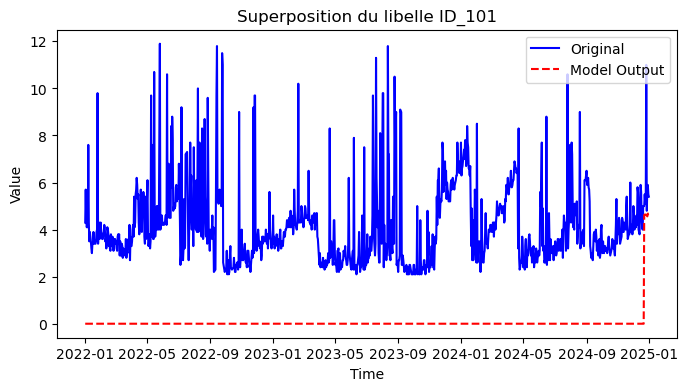

In [75]:
# Récupérer et afficher un libelle spécifique
libelle=3

# récupération du signal original
mask=data_resampled['unique_id']==list_libelle[libelle]
x = data_resampled[mask]['ds'].values
y_original = data_resampled[mask]['y'].values

# Inférence sur la fin de courbe
last_idx = len(DLDS) - 1 # dernier indice du dataset
data, label = DLDS[last_idx]  # récupère le dernier élément
print(DLDS.plage_date(last_idx))
input_tensor = data.unsqueeze(0).to(device)  # ajout dimension Batch, shape [1, C, W]
model.eval()
with torch.no_grad():
    output = model(input_tensor)
y_pred = output[0, libelle].cpu().numpy()

# ajoute de zéros au début
pad_length = len(y_original) - len(y_pred)
y_pred_padded = np.pad(y_pred, (pad_length, 0), mode='constant', constant_values=0)


# impression
plt.figure(figsize=(8, 4))
plt.plot(x, y_original, label="Original", color="blue")
plt.plot(x, y_pred_padded, label="Model Output", color="red", linestyle="--")
plt.title(f"Superposition du libelle {list_libelle[libelle]}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()